## DenseNetwork 구현 및 학습

In [1]:
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## 하이퍼 파라미터

In [2]:
EPOCHS = 10

DEBUG_MODE = False # 채널의 변화를 확인하고 싶을 경우 True로 설정

## Dense Unit 구현

In [3]:
class DenseUnit(tf.keras.Model):
    def __init__(self, filter_out, kernel_size):
        super(DenseUnit, self).__init__()
        self.bn = tf.keras.layers.BatchNormalization()
        self.conv = tf.keras.layers.Conv2D(filter_out, kernel_size, padding='same')
        self.concat = tf.keras.layers.Concatenate()

    def call(self, x, training=False, mask=None): # x: (Batch, H, W, Ch_in)
        h = self.bn(x, training=training)
        h = tf.nn.relu(h)
        h = self.conv(h) # h: (Batch, H, W, filter_output)
        
        # 초기 입력값(X)에 Convolution된 값을 합해주어야 함
        return self.concat([x, h]) # (Batch, H, W, (Ch_in + filter_output))

## Dense Layer 구현

In [4]:
class DenseLayer(tf.keras.Model):
    def __init__(self, num_unit, growth_rate, kernel_size):
        super(DenseLayer, self).__init__()
        self.sequence = list()
        for idx in range(num_unit):
            self.sequence.append(DenseUnit(growth_rate, kernel_size))

    def call(self, x, training=False, mask=None):
        for unit in self.sequence:
            x = unit(x, training=training)
        return x

## Transition Layer 구현

In [5]:
class TransitionLayer(tf.keras.Model):
    def __init__(self, filters, kernel_size):
        super(TransitionLayer, self).__init__()
        self.conv = tf.keras.layers.Conv2D(filters, kernel_size, padding='same')
        self.pool = tf.keras.layers.MaxPool2D()

    def call(self, x, training=False, mask=None):
        x = self.conv(x)
        return self.pool(x)

## 모델 정의

In [6]:
class DenseNet(tf.keras.Model):
    def __init__(self):
        super(DenseNet, self).__init__()
        
        # 입력으로 이미지(28 x 28 x 1)를 받아서 Convolution 작업을 진행하기 위한 설정
        self.conv1 = tf.keras.layers.Conv2D(8, (3, 3), padding='same', activation='relu') # 28x28x8
        
        self.dl1 = DenseLayer(2, 4, (3, 3)) # 28x28x16
        self.tr1 = TransitionLayer(16, (3, 3)) # 14x14x16
        
        self.dl2 = DenseLayer(2, 8, (3, 3)) # 14x14x32
        self.tr2 = TransitionLayer(32, (3, 3)) # 7x7x32
        
        self.dl3 = DenseLayer(2, 16, (3, 3)) # 7x7x64
        
        self.flatten = tf.keras.layers.Flatten() 
        
        self.dense1 = tf.keras.layers.Dense(128, activation='relu')
        self.dense2 = tf.keras.layers.Dense(10, activation='softmax')       

    def call(self, x, training=False, mask=None):
        
        if DEBUG_MODE:
            print(x.shape)
            x = self.conv1(x)
            print(x.shape)
            x = self.dl1(x, training=training)
            print(x.shape)
            x = self.tr1(x)
            print(x.shape)
            x = self.dl2(x, training=training)
            print(x.shape)
            x = self.tr2(x)
            print(x.shape)
            x = self.dl3(x, training=training)
            print(x.shape)
        else:
            x = self.conv1(x)
            x = self.dl1(x, training=training)
            x = self.tr1(x)
            x = self.dl2(x, training=training)
            x = self.tr2(x)
            x = self.dl3(x, training=training)

        x = self.flatten(x)
        x = self.dense1(x)
        return self.dense2(x)
        

## 학습, 테스트 루프 정의

In [7]:
# Implement training loop
@tf.function
def train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy):
    with tf.GradientTape() as tape:
        predictions = model(images, training=True)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)

    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    train_loss(loss)
    train_accuracy(labels, predictions)

# Implement algorithm test
@tf.function
def test_step(model, images, labels, loss_object, test_loss, test_accuracy):
    predictions = model(images, training=False)

    t_loss = loss_object(labels, predictions)
    test_loss(t_loss)
    test_accuracy(labels, predictions)

## 데이터셋 준비


(28, 28)


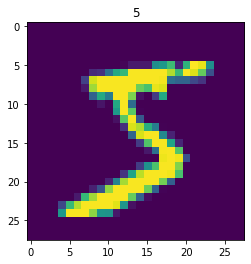

(28, 28, 1)


In [8]:
mnist = tf.keras.datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0

# 이미지 구조 및 값 확인
#print(len(x_train), len(x_test))
#print(x_train.shape)
print(x_train[0].shape)

# 이미지와 레이블 확인
plt.figure()
plt.imshow(x_train[0])
plt.title(y_train[0])
plt.show()

x_train = x_train[..., tf.newaxis].astype(np.float32)
x_test = x_test[..., tf.newaxis].astype(np.float32)

print(x_train[0].shape)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

## 학습 환경 정의
### 모델 생성, 손실함수, 최적화 알고리즘, 평가지표 정의

In [9]:
# Create model
model = DenseNet()

# Define loss and optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()

# Define performance metrics
train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(name='test_accuracy')

## 학습 루프 동작

In [10]:
# 시간측정 필요. 노트북의 경우 1 epoch당 5분 정도 소요됨
t = time.time()
for epoch in range(EPOCHS):
    for images, labels in train_ds:
        train_step(model, images, labels, loss_object, optimizer, train_loss, train_accuracy)

    for test_images, test_labels in test_ds:
        test_step(model, test_images, test_labels, loss_object, test_loss, test_accuracy)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch + 1,
                          train_loss.result(),
                          train_accuracy.result() * 100,
                          test_loss.result(),
                          test_accuracy.result() * 100))
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()
    ct = time.time()
    print('{} seconds elapsed.'.format(ct - t))
    t = ct    

Epoch 1, Loss: 0.12163101881742477, Accuracy: 96.45500183105469, Test Loss: 0.06184300035238266, Test Accuracy: 98.3499984741211
278.54005551338196 seconds elapsed.
Epoch 2, Loss: 0.05761370062828064, Accuracy: 98.25, Test Loss: 0.06444831937551498, Test Accuracy: 98.0
277.5988121032715 seconds elapsed.
Epoch 3, Loss: 0.04787561669945717, Accuracy: 98.62667083740234, Test Loss: 0.05427902191877365, Test Accuracy: 98.44999694824219
279.4707112312317 seconds elapsed.
Epoch 4, Loss: 0.040346283465623856, Accuracy: 98.88333129882812, Test Loss: 0.04425894469022751, Test Accuracy: 98.91999816894531
277.70033717155457 seconds elapsed.
Epoch 5, Loss: 0.03770081326365471, Accuracy: 98.98333740234375, Test Loss: 0.04938366264104843, Test Accuracy: 98.65999603271484
273.49183225631714 seconds elapsed.
Epoch 6, Loss: 0.02988475374877453, Accuracy: 99.1933364868164, Test Loss: 0.11212777346372604, Test Accuracy: 98.0
275.29219818115234 seconds elapsed.
Epoch 7, Loss: 0.02537831850349903, Accuracy: